In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
    
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

np.set_printoptions(suppress=True)

2024-02-06 14:40:38.076377: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 14:40:38.076441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 14:40:38.076463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 14:40:38.082992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df1 = pd.read_csv('data/activity_df_1.csv')
df2 = pd.read_csv('data/activity_df_12.csv')

In [3]:
times1 = df1.unixtime.values

behaviours = df1.behaviours.values

behaviours1 = [None]*len(behaviours)
for i in range(len(behaviours)):
    behaviours1[i] = ast.literal_eval(behaviours[i])
behaviours1 = np.array(behaviours1).reshape((-1,180))

times1 = times1[:,None] + np.arange(180)*10


In [4]:
times2 = df2.unixtime.values

behaviours = df2.behaviours.values

behaviours2 = [None]*len(behaviours)
for i in range(len(behaviours)):
    behaviours2[i] = ast.literal_eval(behaviours[i])
behaviours2 = np.array(behaviours2).reshape((-1,180))

times2 = times2[:,None] + np.arange(180)*10


In [5]:
times = np.concatenate((times1,times2))[...,None]
behaviours = np.concatenate((behaviours1,behaviours2))

times = times - (times.min()//(24*60*60))*24*60*60
# times = times % (24*60*60)

times = times.astype(np.float64)/60 + (3*60) # convert to minutes and add 180 to shift to TZ time
behaviours = behaviours.astype(np.float64)
times = times.reshape((-1,1))
behaviours = behaviours.reshape((-1,))

In [6]:
dtype = np.float64
amplitude = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='amplitude')
length_scale = tfp.util.TransformedVariable(
    10., tfb.Softplus(), dtype=dtype, name='length_scale')
kernel = tfk.ExpSinSquared(
    period=np.float64(60*24.),
    amplitude=amplitude,
    length_scale=length_scale)

num_outputs = 4
# Create trainable inducing point locations and variational parameters.
num_inducing_points_ = 24
inducing_index_points = tf.Variable(np.linspace(0., 24*60., num_inducing_points_,endpoint=False)[..., np.newaxis], dtype=dtype, name='inducing_index_points', trainable=False)

index_points =  np.linspace(0., 24*60., 49,endpoint=True)[..., np.newaxis].astype(dtype)
    

observation_noise_variance = tfp.util.TransformedVariable(1., tfb.Softplus(), dtype=dtype, name='observation_noise_variance')

variational_inducing_observations_loc = tf.Variable(np.zeros([num_outputs, num_inducing_points_], dtype=dtype), name='variational_inducing_observations_loc')

Ku = kernel.matrix(inducing_index_points, inducing_index_points)
# variational_inducing_observations_scale_init = np.linalg.cholesky(Ku + np.eye(num_inducing_points_)*1e-6)
variational_inducing_observations_scale_init = tf.Variable(
    np.eye(num_inducing_points_, dtype=dtype),
    name='variational_inducing_observations_scale')

variational_inducing_observations_scale = tf.Variable(np.tile(variational_inducing_observations_scale_init[None, :, :], [num_outputs, 1, 1]), 
                                                      name='variational_inducing_observations_scale')


2024-02-06 14:40:41.442194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13621 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5
2024-02-06 14:40:41.561217: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [7]:
def log_prob(observations, f):
    berns = tfd.Independent(tfd.Categorical(logits=tf.transpose(f, perm=[1,2,0])), 1) #(20, 64, 4), n_quadrature, bs, n_outputs
    return berns.log_prob(observations) #sparse_softmax_cross_entropy_with_logits: have logits of shape [batch_size, num_classes] and have labels of shape [batch_size]


In [8]:


vgp = tfd.VariationalGaussianProcess(
    kernel,
    index_points=index_points,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=variational_inducing_observations_loc, #TensorShape([6, 30])
    variational_inducing_observations_scale=variational_inducing_observations_scale, #TensorShape([6, 30, 30])
    observation_noise_variance=0.)



In [9]:
times

array([[  873.85      ],
       [  874.01666667],
       [  874.18333333],
       ...,
       [46570.11666667],
       [46570.28333333],
       [46570.45      ]])

In [10]:

optimizer = tf.optimizers.Adam(learning_rate=.01)

@tf.function
def optimize(x_train_batch, y_train_batch, kl_weight):
    with tf.GradientTape() as tape:
        # Create the loss function we want to optimize.
        recon = vgp.surrogate_posterior_expected_log_likelihood(
          observations=y_train_batch,
          observation_index_points=x_train_batch,
          log_likelihood_fn=log_prob,
          quadrature_size=20)

        elbo = -tf.reduce_sum(recon) + kl_weight*tf.reduce_sum(vgp.surrogate_posterior_kl_divergence_prior())

    grads = tape.gradient(elbo, vgp.trainable_variables)
    optimizer.apply_gradients(zip(grads, vgp.trainable_variables))
    return elbo


In [12]:
batch_size = 1024
num_iters = 2000
num_logs = 20
num_training_points_ = times.shape[0]

kl_weight = batch_size/num_training_points_
for i in range(num_iters):
    batch_idxs = np.random.randint(num_training_points_, size=[batch_size])
    x_train_batch = times[batch_idxs, ...]
    y_train_batch = behaviours[batch_idxs]
    loss = optimize(x_train_batch, y_train_batch, kl_weight )

    if i % (num_iters / num_logs) == 0 or i + 1 == num_iters:
        print(i, loss.numpy())


Instructions for updating:
the `jitter` property of `tfd.GaussianProcess` is deprecated; use the `marginal_fn` property instead.


2024-02-06 14:40:53.775859: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5584d4e67590
2024-02-06 14:40:53.923794: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3d400283a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-06 14:40:53.923829: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-02-06 14:40:53.928723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-06 14:40:54.044782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-06 14:40:54.144835: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0 271409.2925844422
100 13560.23789466712
200 3362.268126300012
300 2034.395416176954
400 1677.6174600862157
500 1545.5929833673279
600 1486.3799735730806
700 1455.9089161616369
800 1421.3524334833528
900 1420.3272490129755
1000 1411.4370661903702
1100 1381.271719813898
1200 1390.3993053788026
1300 1397.1125467399247
1400 1390.8659755817062
1500 1385.8771604632207
1600 1389.6515049550333
1700 1385.0133690459536
1800 1379.451914927984
1900 1382.7672465974733
1999 1384.337527657442


In [13]:
cc = []

aa = vgp.sample(10000)#.numpy()


aa = tf.math.softmax(aa,axis=1).numpy()

mean_prob = np.mean(aa,axis=0)
# lci = np.percentile(aa,16,axis=0)
# uci = np.percentile(aa,84,axis=0)

In [44]:
# tf.math.reduce_mean(aa,axis=0)[0]+tf.math.reduce_std(aa,axis=0)[0]
xtime=np.array([np.datetime64('2023') + np.timedelta64(int(k*60), 's') for k in index_points[:,0]])


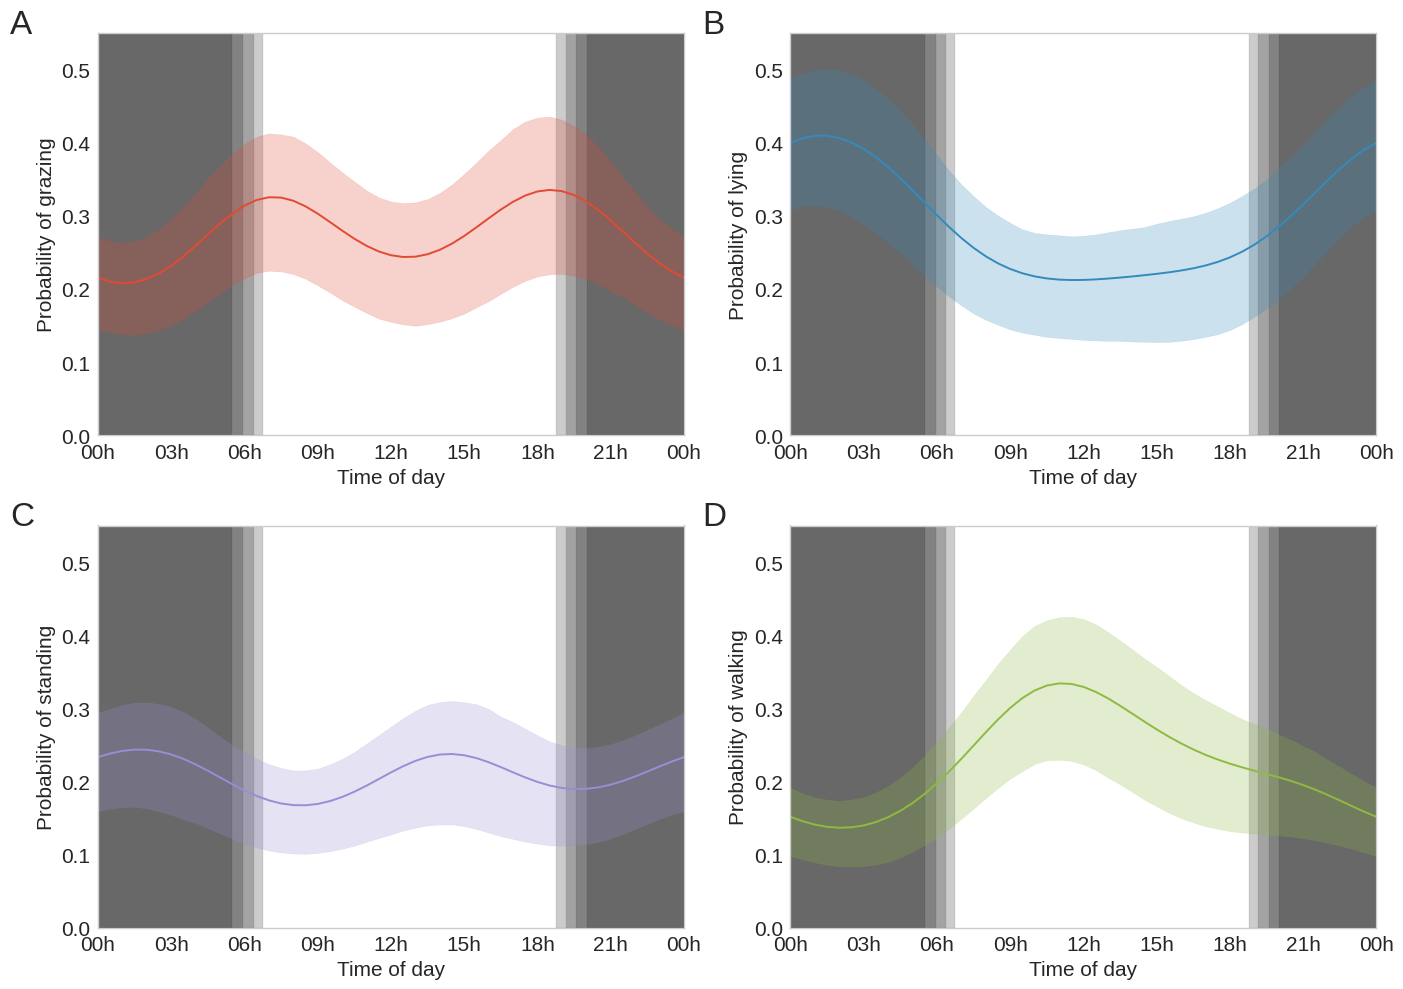

In [45]:



import matplotlib.ticker as tick
plt.style.use('ggplot') 
plt.style.use('seaborn-v0_8-paper') 
plt.style.use('seaborn-v0_8-whitegrid') 

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

myFmt = mdates.DateFormatter('%Hh')


fig, axs = plt.subplots(2, 2, figsize=(14,10))#,gridspec_kw={'width_ratios': [1,1,1.5]})

# ax0 = axs[0, 0].contourf(xx,yy,var_grid,levels=100,cmap='viridis',vmin=0.05,vmax=0.18)
# axs[0, 0].set_aspect('equal', 'box')
# axs[0,0].set_xlabel('x-coordinate',size=15)
# axs[0,0].set_ylabel('y-coordinate',size=15)
# #axs[0,0].set_title('A',loc='center',size=30)
# axs[0,0].text(-0.25,1,'A', size=30, transform=axs[0, 0].transAxes)
# axs[0,0].tick_params(axis='both', which='major', labelsize=15)
# cbar = fig.colorbar(ax0, ax=axs[0, 0],format=tick.FormatStrFormatter('%.2f'))
# cbar.set_label(label='posterior mean velocity amplitude',size=15)
# cbar.ax.tick_params(labelsize=15) 
# tick_locator = tick.MaxNLocator(nbins=7)
# cbar.locator = tick_locator
# cbar.update_ticks()

axs = axs.ravel()

colors = ['C0','C1','C2','C5']
letters = ['A','B','C','D']
ylabels = ['Probability of grazing', 'Probability of lying', 'Probability of standing', 'Probability of walking']


for j in range(4):
    ax = axs[j]
    ax.plot(xtime,mean_prob[j,:],c=colors[j],label='grazing')
    for i in range(1,2):
        lci = np.percentile(aa,5 + i *20,axis=0)
        uci = np.percentile(aa,95 - i*20 ,axis=0)
        # print((95 - i*5) - (5+i*5))
        ax.fill_between(xtime,lci[j,:],uci[j,:],color=colors[j],alpha=0.25,zorder=2)
        # plt.plot(index_points[:,0]/60,lci[j,:],c=colors[j],alpha=0.1)

        # plt.plot(index_points[:,0]/60,uci[j,:],c=colors[j],alpha=0.1)
    # night 00:00 - 05:30
    # astro 05:30 - 05:57
    # naut 05:57 - 06:23
    # civil 06:23 - 06:45
    # day 06:45 - 18:46
    # civil 18:46 - 19:09
    # naut 19:09 - 19:35
    # astro 19:35 - 20:01
    # night 20:01 - 00:00

    ends = [[5,30],[5,57],[6,23],[6,45]]
    starts = [[18,46],[19,9],[19,35],[20,1]]
    for et in ends:
        ax.axvspan(np.datetime64('2023'), np.datetime64('2023') + np.timedelta64(int(et[0]*60*60 + et[1]*60), 's'), alpha=0.2, color='k', zorder=1)
    for st in starts:
        ax.axvspan(np.datetime64('2023') + np.timedelta64(int(st[0]*60*60 + st[1]*60), 's'), np.datetime64('2023')+np.timedelta64(int(24*60*60), 's'), alpha=0.2, color='k', zorder=1)
    ax.set_ylim(0,0.55)
    ax.set_xlim(xtime[0],xtime[-1])
    ax.text(-0.15,1,letters[j], size=24, transform=ax.transAxes)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlabel('Time of day',size=15)
    ax.set_ylabel(ylabels[j],size=15)
    ax.grid(False)

plt.tight_layout()
plt.savefig('activity.png')
plt.show()



# plt.plot(index_points[:,0]/60,mean_prob[1,:],c='C1',label='grazing')
# plt.fill_between(index_points[:,0]/60,lci[1,:],uci[1,:],color='C1',alpha=0.2)
# plt.ylim(0,0.6)
# plt.show()
# plt.plot(index_points[:,0]/60,mean_prob[2,:],c='C2',label='grazing')
# plt.fill_between(index_points[:,0]/60,lci[2,:],uci[2,:],color='C2',alpha=0.2)
# plt.ylim(0,0.6)
# plt.show()
# plt.plot(index_points[:,0]/60,mean_prob[3,:],c='C3',label='grazing')
# plt.fill_between(index_points[:,0]/60,lci[3,:],uci[3,:],color='C3',alpha=0.2)
# plt.ylim(0,0.6)
# plt.show()

# plt.plot(lci[0,:],c='C0',label='grazing')
# plt.plot(uci[0,:],c='C0',label='grazing')
